This notebook addresses the question, "Can we represent a molecule as a graph via a 1D column vector or a 2D matrix of fixed length, with maximum number of atoms n_rows?" Then, can we use this representation to learn neural fingerprints? E.g., can we make an aromatic ring detector? 

Scheme:
feature_matrix = X
for each ligand:
    choose a central atom. this can be the atom (node) that minimizes distance to furthest heavy atom in graph.
    set first row of X to be this central atom
    set next four rows to be the atoms bonded to that centrl atom
        set zeros for rows where row ind > n_bonds of atom
    for each of those atoms:
        repeat. find their neighbors. add to matrix.

algorithm: breadth-first search:
1. create networkx graph based on molecule
2. find "central" atom (different strategies)
3. define atom matrix of size (1+4+4*3^(L-1)) x (n_features_per_atom)
4. start atom queue q
5. central_atom.layer = 0; central_atom.row_idx = 0;
6. q.enqueue(central_atom)
7. define adjacency matrix of size (1+4+4*3^(L-1)) x 4

def get_row_idx(curr_layer, prev_row_idx, curr_neighbor_idx):
    if curr_layer == 0:
        return(0)
    if curr_layer == 1:
        row_idx = 1 + curr_neighbor_idx
    if layer == 2:
        last_max = 5
        row_idx = last_max + (3*(prev_row_idx-last_max)) + curr_neighbor_idx
    if layer > 2:
        last_max = 5 + 4*3^(curr_layer-2) 
        row_idx = last_max + 3*(prev_row_idx-last_max) + curr_neighbor_idx
    return(row_idx)
    

while q.is_not_empty():
    a = q.dequeue()
    a.visited = True
    for n_idx, n in enumerate(a.neighbors()):
        if not n.visited:
            row_idx = c
            n.layer = a.layer + 1
            row_idx = get_row_idx(n.layer, a.row_idx, n_idx)
            n.row_idx = row_idx
            adj_matrix[a.row_idx][n_idx] = n.row_idx
            atom_matrix[row_idx][elem_to_idx[n.elem]] = 1

input_matrix = tf.concat([atom_matrix, atom_matrix[adj_matrix[:,0]], atom_matrix[adj_matrix[:,1]], atom_matrix[adj_matrix[:,2]], atom_matrix[adj_matrix[:,3]]

neural net:
h1 = relu([tf.zeros([n_features_per_atom, 4]) * input_matrix + bias))
h1_conc = tf.concat([h1, h1[adj_matrix[:,0], ..., h1[adj_matrix[:,3])

repeat h1 to get h2


dihedral predictor pseudocode:

get bonds for molecule
create networkx graph out of molecule (use atom indices)

for each edge:
   for neighbor_i in atom_i.neighbors():
       if neighbor_i == atom_j: continue
       for neighbor_j in atom_j.neighbors():
           if neighbor_j == atom_i: continue
           dihedrals.append((neighbor_i, atom_i, neighbor_j, atom_j))
           check to make sure (atom_j, neighbor_j, atom_i, neighbor_i)) not already in list

for dihedral in dihedrals:
    angle =  rdMolTransforms.GetDihedralDeg(c, 0,1,2,3)


In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix

In [3]:
def get_torsions_angles(mol):
    torsion_tuples = []
    for bond in mol.GetBonds():
        atom_i = bond.GetBeginAtom()
        atom_j = bond.GetEndAtom()
        if atom_i.IsInRing() or atom_j.IsInRing():
            continue
        for neighbor_i in atom_i.GetNeighbors():
            if neighbor_i.GetIdx() == atom_j.GetIdx():
                continue
            
            for neighbor_j in atom_j.GetNeighbors():
                if neighbor_j.GetIdx() == atom_i.GetIdx():
                    continue
                torsion_tuple = (neighbor_i.GetIdx(), atom_i.GetIdx(), atom_j.GetIdx(), neighbor_j.GetIdx())
                reverse_torsion_tuple = (neighbor_j.GetIdx(), atom_j.GetIdx(), atom_i.GetIdx(), neighbor_i.GetIdx())
                if torsion_tuple not in torsion_tuples and reverse_torsion_tuple not in torsion_tuples:
                    torsion_tuples.append(torsion_tuple)
    c = mol.GetConformer(0)
    torsions = []
    torsion_matrix = np.zeros((250,1))
    torsion_indices = np.zeros((250,200,4)).astype(np.uint8)
    for i, torsion_tuple in enumerate(torsion_tuples):
        torsion_matrix[i] = np.abs(rdMolTransforms.GetDihedralRad(c, *torsion_tuple))
        torsion_indices[i][torsion_tuple[0]][0] = 1
        torsion_indices[i][torsion_tuple[1]][1] = 1
        torsion_indices[i][torsion_tuple[2]][2] = 1
        torsion_indices[i][torsion_tuple[3]][3] = 1
    return((torsion_indices, csr_matrix(torsion_matrix)))
                

In [4]:
def featurize_mols(mol_files):
    featurizer = AdjacencyFingerprint(max_n_atoms=200)
    features = []
    for mol_file in mol_files:
        mol = Chem.MolFromMol2File(mol_file)
        if mol is None:
            features.append(None)
            continue
        torsions = get_torsions_angles(mol)
        graph_feat = featurizer.featurize([mol])[0]
        features.append((mol_file, torsions, graph_feat))
    return(features)

In [5]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [6]:
import pickle
feature_file = "./dihedral_features_pdbbind.pkl"
#if not os.path.exists(feature_file):
if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = [f for f in find_files(pdbbind_dir, "*ligand.mol2")][:128]
    features = featurize_mols(ligand_files)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

In [7]:
features = [f for f in features if f is not None and len(np.where(f[1][1].toarray() == 0)[0]) < 250][0:1]

In [8]:
len(features)

1

In [41]:
from model import DCGAN
gan = DCGAN(n_layers=2, batch_size=1,
                                 n_atom_types=1,
                                 max_n_atoms=200,
                                 max_valence=6,
                                 n_tasks=1,
                                 learning_rate=1e-3,
                                 L_list = [50, 50, 50, 50],
                                 epsilon=1e-8,
                                 beta1=0.9,
                                 dropout=1.0)

gen.h1
Tensor("generator/add_1:0", shape=(10000, 1), dtype=float32)
gen.h1
Tensor("generator_1/add_1:0", shape=(10000, 1), dtype=float32)
None


In [42]:
gan.train(features, n_epochs=100)

Training epoch 0
0.60805
1.49907
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
0.52482
1.57451
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
Training epoch 15
Training epoch 16
Training epoch 17
Training epoch 18
Training epoch 19
Training epoch 20
0.460055
1.64954
Training epoch 21
Training epoch 22
Training epoch 23
Training epoch 24
Training epoch 25
Training epoch 26
Training epoch 27
Training epoch 28
Training epoch 29
Training epoch 30
0.412811
1.72222
Training epoch 31
Training epoch 32
Training epoch 33
Training epoch 34
Training epoch 35
Training epoch 36
Training epoch 37
Training epoch 38
Training epoch 39
Training epoch 40
0.37117
1.79128
Training epoch 41
Training epoch 42
Training epoch 43
Training epoch 44
Training epoch 45
Training epoch 46
Training epoch 47
Training epoch 48
Training epoch 49
Training epoch 50
0.335666
1

In [43]:
res = gan.predict()

In [44]:
res

array([[  8.26161671],
       [ 18.00482559],
       [ 14.10464096],
       ..., 
       [ 21.83512688],
       [ 14.42951775],
       [ 21.71645737]], dtype=float32)

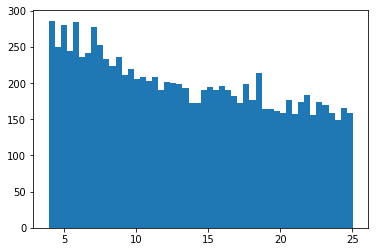

In [45]:
plt.hist(res, bins=50)
plt.show()

In [30]:
features[0][1][1].toarray()

array([[ 0.91292151],
       [ 3.09695411],
       [ 1.06725919],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

In [43]:
features[0][1][1].toarray()

array([[ 0.91292151],
       [ 3.09695411],
       [ 1.06725919],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

In [12]:
preds = []
for i in range(0,100):
    preds.append(gan.predict(features)[0][2])

In [13]:
np.mean(preds)

12.944489

In [ ]:
features[0][2].atom_features